In [1]:
bpf = 'positive-words.txt'
bnf = 'negative-words.txt'
nrc = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
syuzhet = 'syuzhet.csv'
gi = 'gi.csv'

In [3]:
import collect_lexicon as cl

In [4]:
combo = cl.collect(bpf, bnf, nrc, syuzhet, gi)

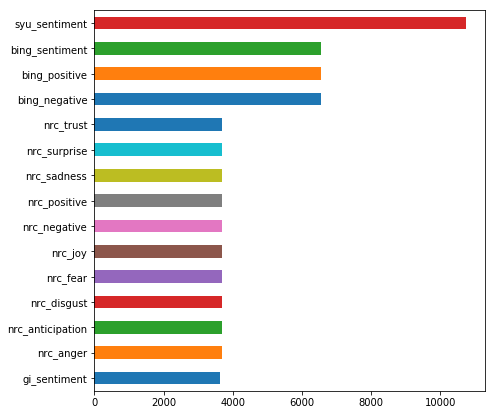

In [6]:
%matplotlib inline

combo.count().sort_values().plot(kind='barh', figsize=(7,7))

In [16]:
import syuzhet as syu

tdb = 'Great-Expectations.db'
tokens, by_chapter, by_para, xticks1, by_sent, xticks2 = syu.sent_by_OHCO(tdb)

In [17]:
tokens.sample(20)

pos     token_str  punc  num  \
chap_num para_num sent_num token_num                                 
0        1862     0        8           JJ           old     0    0   
         1813     2        23         VBZ            is     0    0   
         2201     3        8           DT          some     0    0   
         1817     0        8           VB        arrive     0    0   
         1244     0        14          NN       morning     0    0   
         675      0        12          IN          with     0    0   
         1006     2        49          VB          make     0    0   
         3568     0        29          RB  considerably     0    0   
         2373     4        30          JJ          such     0    0   
         1786     3        22          DT           the     0    0   
         177      0        12          NN  presentiment     0    0   
         1784     0        8          VBP       suppose     0    0   
         1382     0        27          CC           and     0    0   
         1290     0        1          NNP            Go     0    0   
         3089     5        45         NNS       fingers     0    0   
         841      4        12          VB          have     0    0   
         1618     2        28          CC            or     0    0   
         2671     0        33          NN    subsequent     0    0   
         1420     4        14          TO            to     0    0   
         3002     1        31         POS            's     0    0   

                                          term_str  term_id  nrc_anger  \
chap_num para_num sent_num token_num                                     
0        1862     0        8                   old     6518        NaN   
         1813     2        23                   is     5254        NaN   
         2201     3        8                  some     8804        NaN   
         1817     0        8                arrive      598        NaN   
         1244     0        14              morning     6143        NaN   
         675      0        12                 with    10643        NaN   
         1006     2        49                 make     5826        NaN   
         3568     0        29         considerably     2065        NaN   
         2373     4        30                 such     9248        NaN   
         1786     3        22                  the     9564        NaN   
         177      0        12         presentiment     7224        NaN   
         1784     0        8               suppose     9323        NaN   
         1382     0        27                  and      435        NaN   
         1290     0        1                    go     4246        NaN   
         3089     5        45              fingers     3769        NaN   
         841      4        12                 have     4538        NaN   
         1618     2        28                   or     6558        NaN   
         2671     0        33           subsequent     9226        NaN   
         1420     4        14                   to     9708        NaN   
         3002     1        31                   's       54        NaN   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
chap_num para_num sent_num token_num                                            
0        1862     0        8                       NaN          NaN       NaN   
         1813     2        23                      NaN          NaN       NaN   
         2201     3        8                       NaN          NaN       NaN   
         1817     0        8                       NaN          NaN       NaN   
         1244     0        14                      NaN          NaN       NaN   
         675      0        12                      NaN          NaN       NaN   
         1006     2        49                      NaN          NaN       NaN   
         3568     0        29                      NaN          NaN       NaN   
         2373     4        30                      NaN    

### By chapter

### By paragraph

In [18]:
import sqlite3
import pandas as pd

with sqlite3.connect('lexicons.db') as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

emo_cols = combo.columns
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

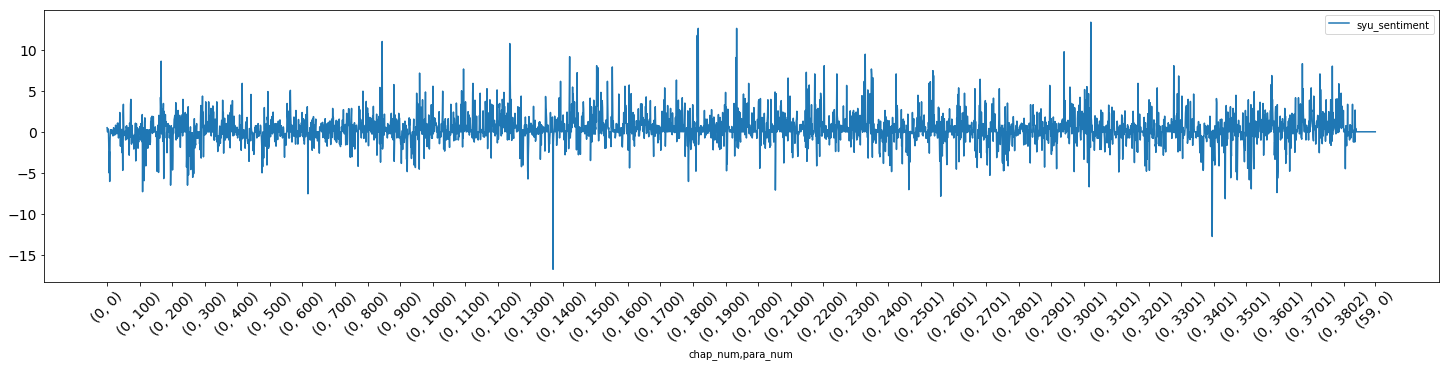

In [19]:
by_para['syu_sentiment'].plot(**FIG, xticks=xticks1)

### FFT

In [20]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
emo = 'syu_sentiment'
X = syu.get_transformed_values(by_sent[emo].values, **FFTCFG)

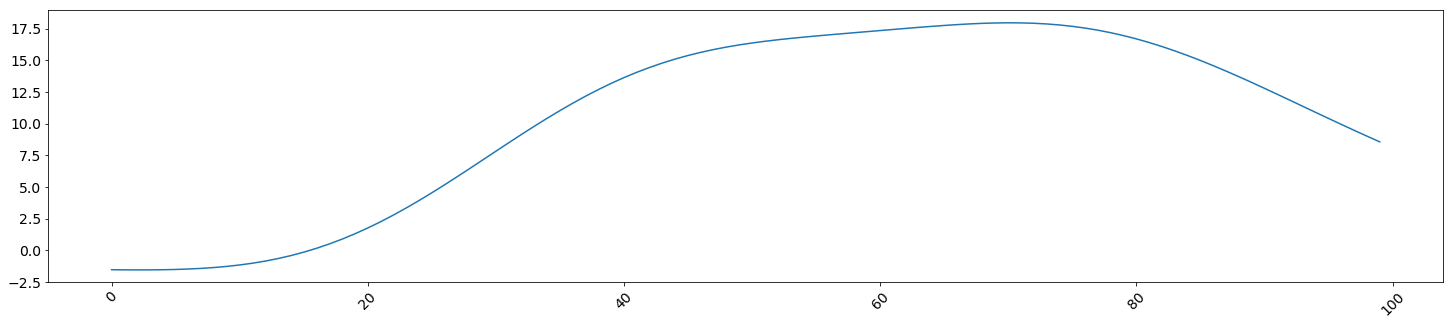

In [21]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### DCT

In [22]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = syu.get_dct_transform(by_sent[emo].values, **FFTCFG1)

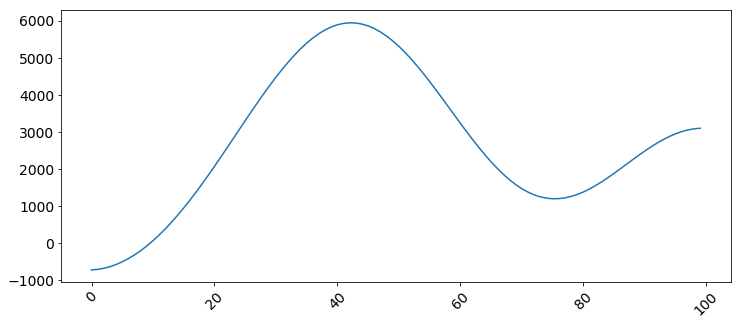

In [23]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using rolling

In [24]:
# Config for sentences
CFG1 = dict(
    win_type='triang',
    window=1000,
    center=True
)

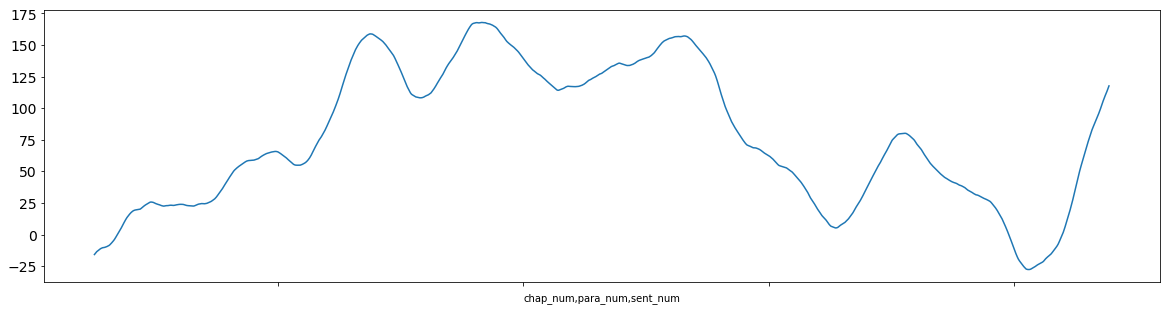

In [25]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [26]:
# Config for tokens
CFG2 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
CFG2['window']

20986

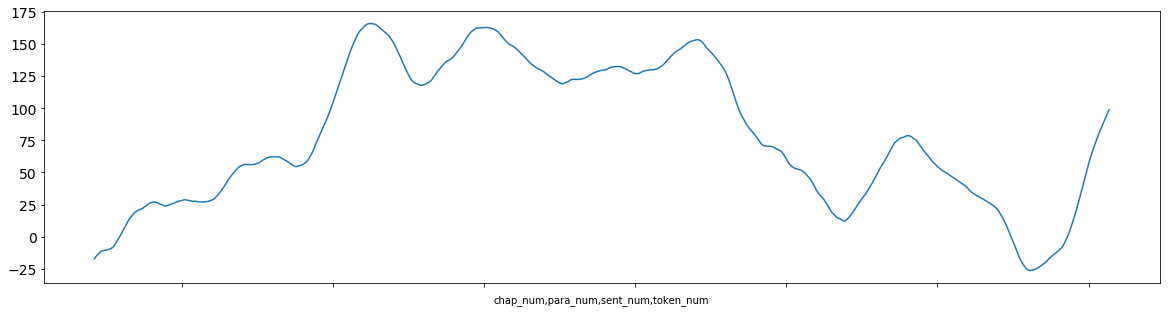

In [27]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

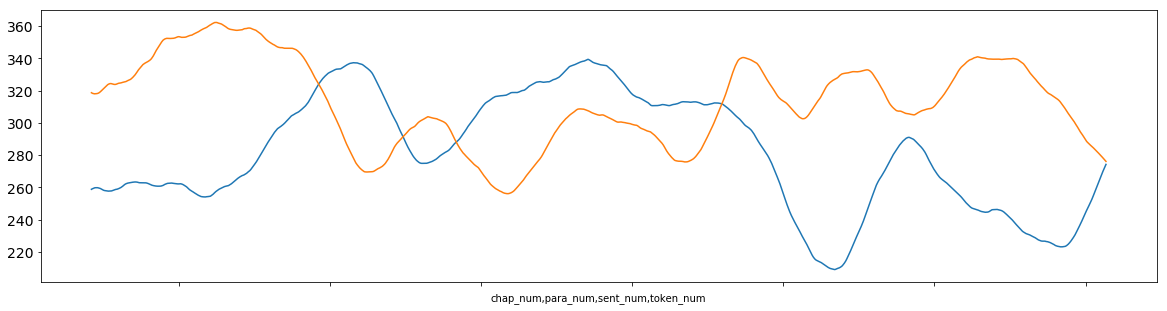

In [28]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)

## Multinominal emotions

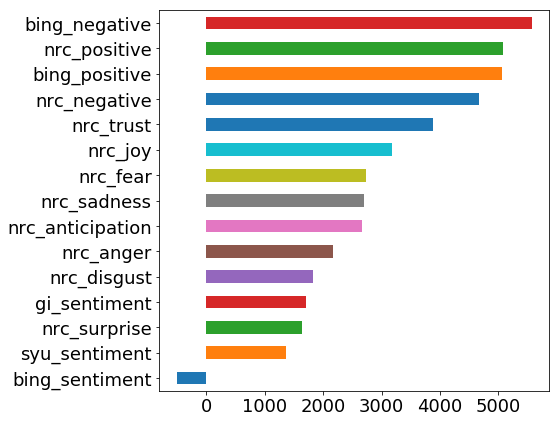

In [29]:
EOM = tokens[emo_cols].reset_index(drop=True)
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

### Shape data for KDE function

In [30]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [31]:
# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [33]:
import numpy as np
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

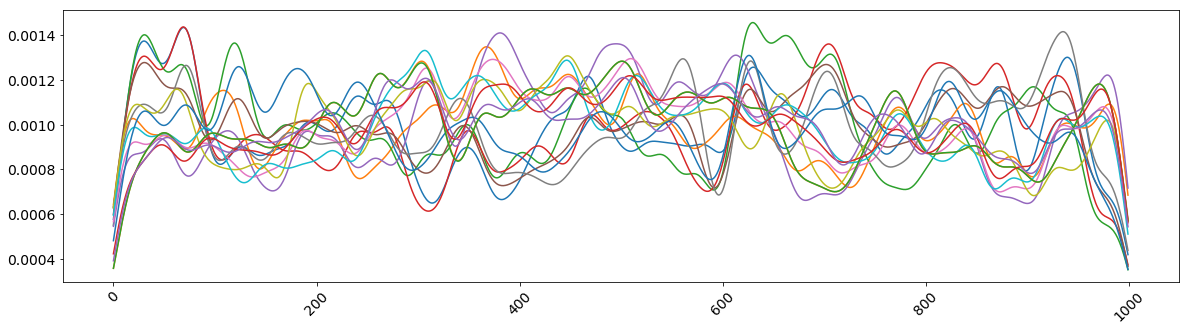

In [34]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

### Compare KDE to Rolling

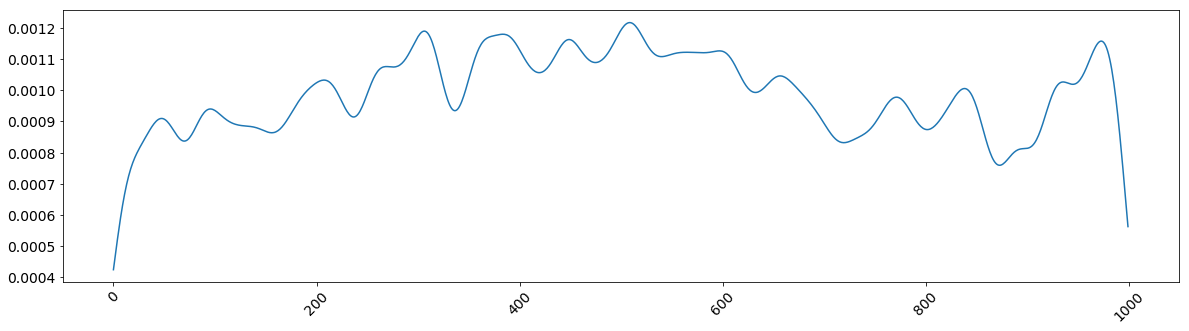

In [35]:
PLOTS[emo].plot(**FIG)

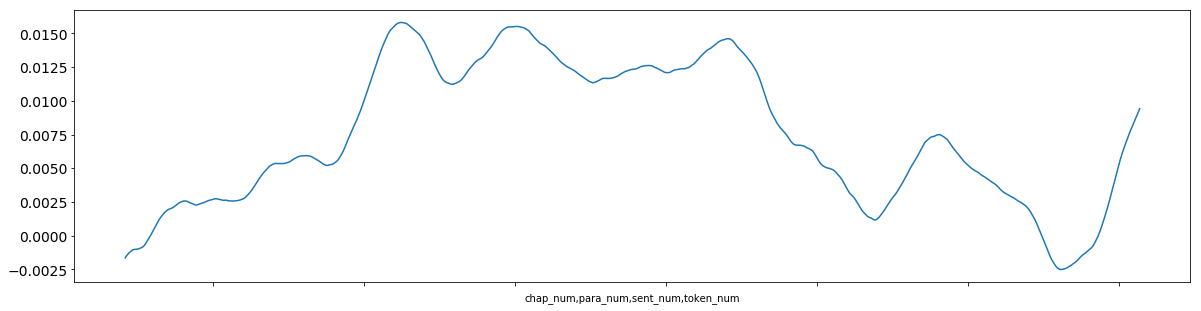

In [36]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)